In [5]:
## Movie Success Prediction and Sentiment Analysis

'''This notebook analyzes movie data to:
1. Study genre-wise sentiment trends
2. Analyze sentiment in movie reviews
3. Predict box office success using various features'''

!pip install pandas numpy scikit-learn nltk vaderSentiment matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Found existing installation: vaderSentiment 3.3.2
Uninstalling vaderSentiment-3.3.2:
  Successfully uninstalled vaderSentiment-3.3.2
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
plt.style.use('seaborn')
sns.set_palette('husl')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DARSHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\DARSHAN\AppData\Local\Temp\ipykernel_15560\2705237783.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
## 1. Data Loading and Initial Exploration
df = pd.read_csv('merged_movie_dataset.csv')
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
df.head()

Dataset Shape: (3126, 11)

Columns: ['title', 'year', 'genre', 'score', 'budget', 'gross', 'runtime', 'company', 'title_lower', 'cast', 'crew']

Sample Data:


,title,year,genre,score,budget,gross,runtime,company,title_lower,cast,crew
0,The Shining,1980,Drama,8.4,19000000.0,46998772.0,146.0,Warner Bros.,the shining,"[{""cast_id"": 18, ""character"": ""Jack Torrance"",...","[{""credit_id"": ""52fe426bc3a36847f801d3a1"", ""de..."
1,The Blue Lagoon,1980,Adventure,5.8,4500000.0,58853106.0,104.0,Columbia Pictures,the blue lagoon,"[{""cast_id"": 7, ""character"": ""Emmeline"", ""cred...","[{""credit_id"": ""52fe4418c3a36847f8081faf"", ""de..."
2,Airplane!,1980,Comedy,7.7,3500000.0,83453539.0,88.0,Paramount Pictures,airplane!,"[{""cast_id"": 5, ""character"": ""Ted Striker"", ""c...","[{""credit_id"": ""52fe427ac3a36847f8021c35"", ""de..."
3,Caddyshack,1980,Comedy,7.3,6000000.0,39846344.0,98.0,Orion Pictures,caddyshack,"[{""cast_id"": 10, ""character"": ""Ty Webb"", ""cred...","[{""credit_id"": ""52fe44ae9251416c7503d497"", ""de..."
4,The Blues Brothers,1980,Action,7.9,27000000.0,115229890.0,133.0,Universal Pictures,the blues brothers,"[{""cast_id"": 4, ""character"": ""Elwood Blues (as...","[{""credit_id"": ""52fe424dc3a36847f8013c09"", ""de..."


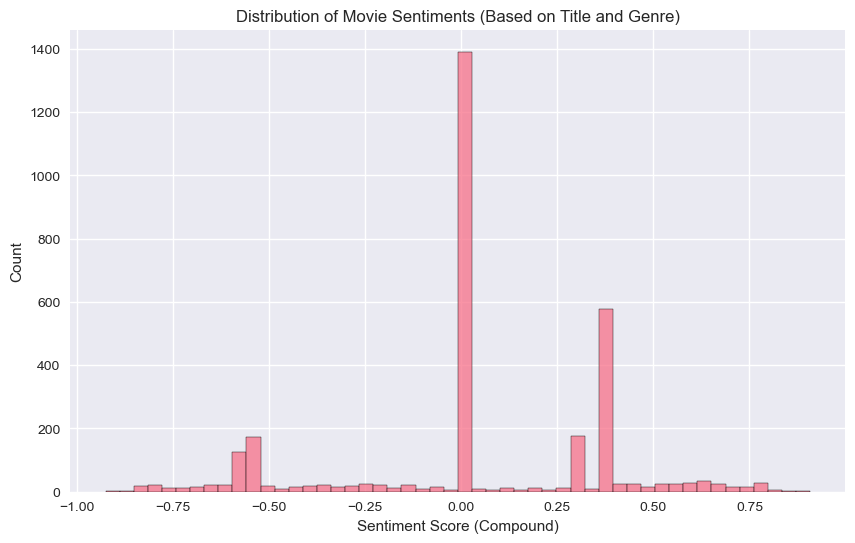

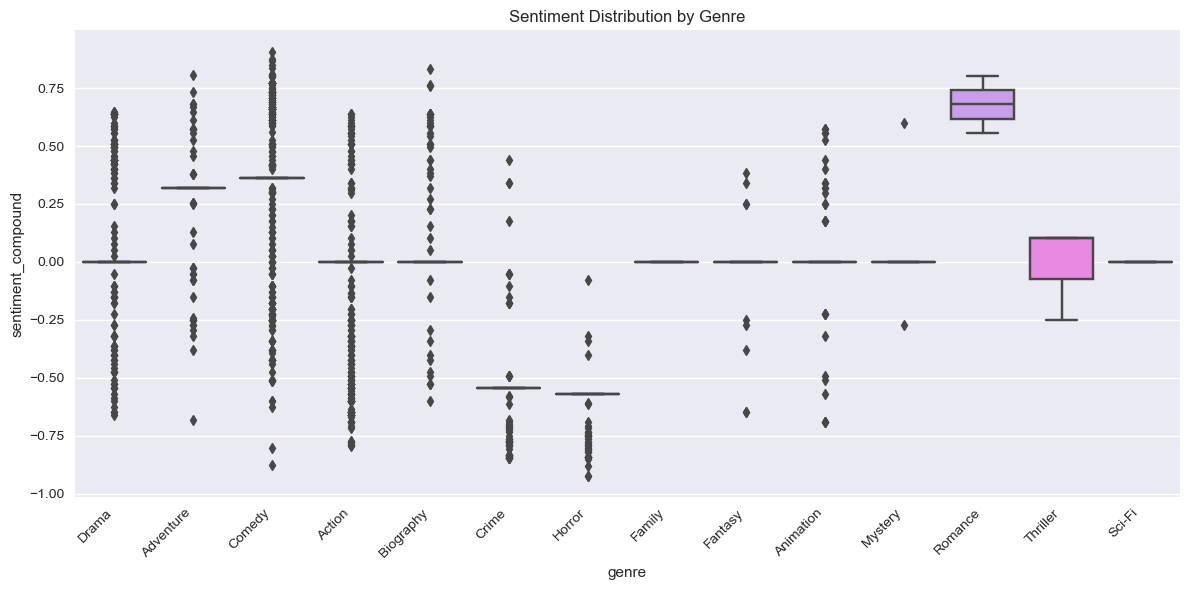


Sentiment Statistics by Genre:
            mean    std  count
genre                         
Action    -0.048  0.214    896
Adventure  0.291  0.185    199
Animation  0.010  0.179    162
Biography  0.057  0.232    178
Comedy     0.342  0.244    809
Crime     -0.548  0.179    204
Drama      0.031  0.218    488
Family     0.000  0.000      3
Fantasy   -0.043  0.258     23
Horror    -0.611  0.111    151
Mystery    0.047  0.264      7
Romance    0.680  0.173      2
Sci-Fi     0.000    NaN      1
Thriller  -0.015  0.204      3


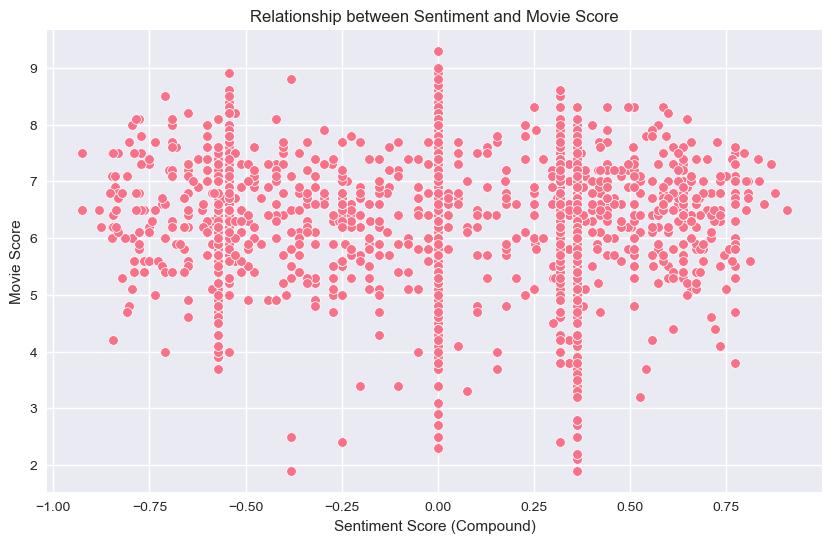

In [9]:
## 2. Initializing VADER and doing sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)
    return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

df['text_for_sentiment'] = df['title'] + ' ' + df['genre']

df['sentiment_scores'] = df['text_for_sentiment'].apply(get_sentiment_scores)
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment_compound', bins=50)
plt.title('Distribution of Movie Sentiments (Based on Title and Genre)')
plt.xlabel('Sentiment Score (Compound)')
plt.show()

# sentiment by genre
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='genre', y='sentiment_compound')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Distribution by Genre')
plt.tight_layout()
plt.show()

# sentiment statistics
print("\nSentiment Statistics by Genre:")
print(df.groupby('genre')['sentiment_compound'].agg(['mean', 'std', 'count']).round(3))

# relationship between sentiment and score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sentiment_compound', y='score')
plt.title('Relationship between Sentiment and Movie Score')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Movie Score')
plt.show()


Model Performance:
                            MSE        R2
Linear Regression  1.957494e+16  0.554845
Random Forest      1.964494e+16  0.553253


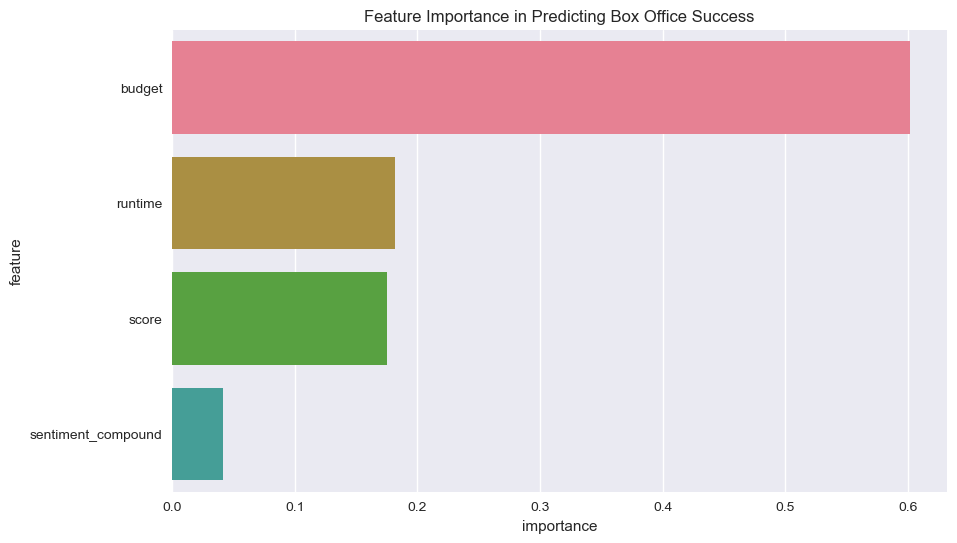

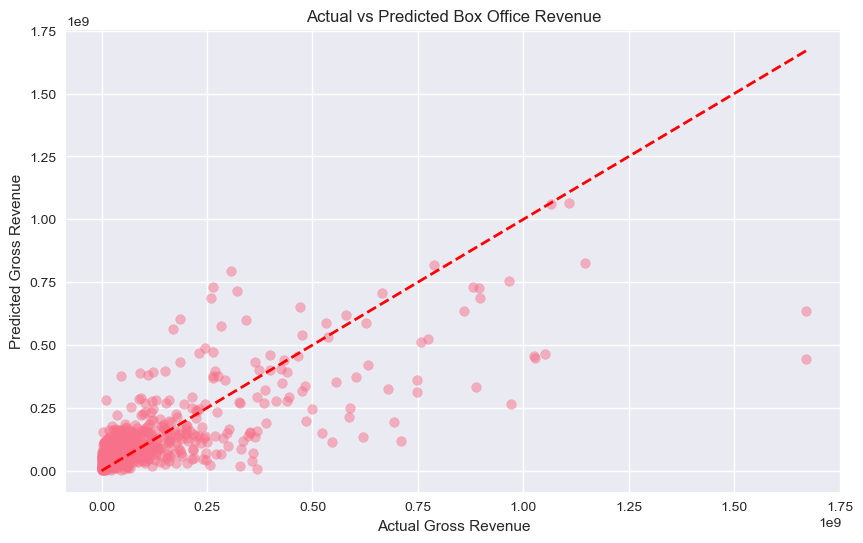


Feature Correlations with Gross Revenue:
gross                 1.000000
budget                0.702334
runtime               0.269440
score                 0.216725
sentiment_compound   -0.038985
Name: gross, dtype: float64


In [10]:
## 3. Prediction Model

# preparing features and data spliting
features = ['budget', 'score', 'runtime', 'sentiment_compound']  # Using available features
X = df[features].fillna(0)
y = df['gross']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model training
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)

# feature and importance for rf
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Box Office Success')
plt.show()

# analysis for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Gross Revenue')
plt.ylabel('Predicted Gross Revenue')
plt.title('Actual vs Predicted Box Office Revenue')
plt.show()

# feature correlations with gross revenue
print("\nFeature Correlations with Gross Revenue:")
correlations = df[features + ['gross']].corr()['gross'].sort_values(ascending=False)
print(correlations)